In [1]:
import sys
sys.path.append('..') 
from ridge_utils.DataSequence import DataSequence
import torch
import pickle
import os
from transformers import BertTokenizerFast
from torch.utils.data import DataLoader
from encoder import Encoder
from data import TextDataset
from train_encoder import train_bert

/jet/home/cpestell/.conda/envs/env_214/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Train Encoder

/var/tmp/ipykernel_97407/1129816233.py:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  raw_text = pickle.load(f)


Loaded 109 podcast stories
Training model with hidden_size=128, num_layers=2
Epoch [1/5], Train Loss: 2.3632, Val Loss: 2.2043
Epoch [2/5], Train Loss: 2.1507, Val Loss: 2.2016
Epoch [3/5], Train Loss: 2.1317, Val Loss: 2.1223
Epoch [4/5], Train Loss: 2.1216, Val Loss: 2.0777
Epoch [5/5], Train Loss: 2.1238, Val Loss: 2.1519
Training model with hidden_size=128, num_layers=4
Epoch [1/5], Train Loss: 2.3558, Val Loss: 2.2426
Epoch [2/5], Train Loss: 2.1721, Val Loss: 2.2107
Epoch [3/5], Train Loss: 2.1460, Val Loss: 2.1886
Epoch [4/5], Train Loss: 2.1195, Val Loss: 2.2665
Epoch [5/5], Train Loss: 2.1293, Val Loss: 2.1671
Training model with hidden_size=128, num_layers=6
Epoch [1/5], Train Loss: 2.3968, Val Loss: 2.1809
Epoch [2/5], Train Loss: 2.2561, Val Loss: 2.3019
Epoch [3/5], Train Loss: 2.3202, Val Loss: 2.3140
Epoch [4/5], Train Loss: 2.2526, Val Loss: 2.2000
Epoch [5/5], Train Loss: 2.2603, Val Loss: 3.1048
Training model with hidden_size=256, num_layers=2
Epoch [1/5], Train Loss

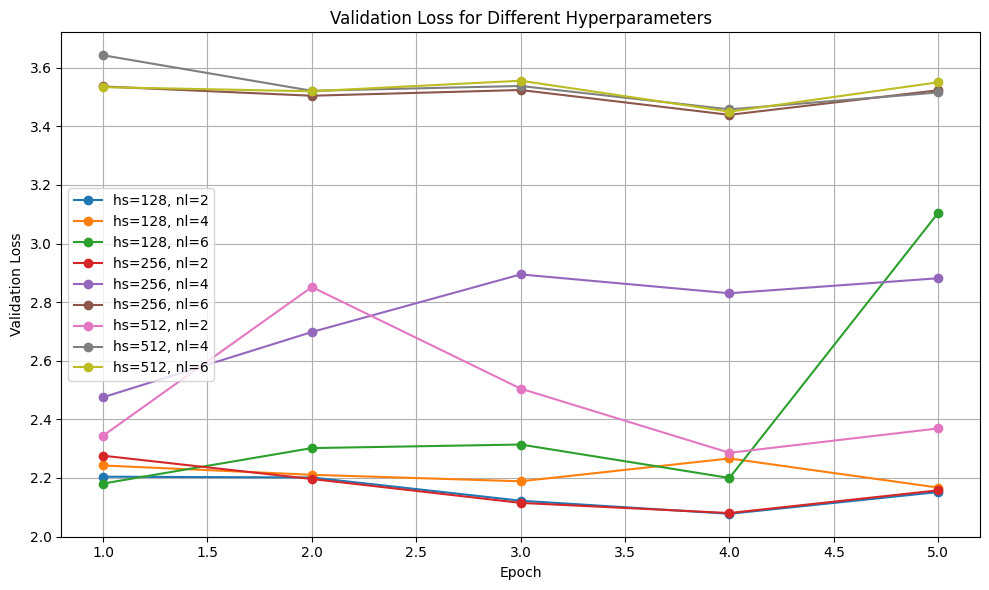

Pretrained encoder saved as pretrained_encoder.pt


In [6]:
# Load the podcast text data
data_path = "/ocean/projects/mth240012p/shared/data"
raw_text_path = os.path.join(data_path, "raw_text.pkl")

with open(raw_text_path, "rb") as f:
    raw_text = pickle.load(f)

print(f"Loaded {len(raw_text)} podcast stories")

# Flatten all the words from all stories into a single list
all_sentences = []
for story in raw_text.values():
    all_sentences.extend(story.data)

# Tokenizer & Dataset
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
dataset = TextDataset(all_sentences, tokenizer, max_len=32)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Create encoder model
device = "cuda" if torch.cuda.is_available() else "cpu"
# encoder = Encoder(vocab_size=tokenizer.vocab_size)
# encoder = encoder.to(device)

import torch
import itertools
import matplotlib.pyplot as plt

# Fixed settings
lr = 3e-4
epochs = 5
batch_size = 32
num_heads = 4
intermediate_size = 512

# Things to tune
hidden_sizes = [128, 256, 512]
num_layers_list = [2, 4, 6]

# Store results
results = {}

# Loop over all combinations
for hidden_size, num_layers in itertools.product(hidden_sizes, num_layers_list):
    print(f"Training model with hidden_size={hidden_size}, num_layers={num_layers}")

    # Initialize new encoder
    encoder = Encoder(
        vocab_size=tokenizer.vocab_size,
        hidden_size=hidden_size,
        num_heads=num_heads,
        num_layers=num_layers,
        intermediate_size=intermediate_size,
        max_len=512
    )
    encoder = encoder.to(device)

    # Train and get losses
    train_losses, val_losses = train_bert(
        model=encoder,
        dataloader=dataloader,
        tokenizer=tokenizer,
        epochs=epochs,
        lr=lr,
        device=device
    )

    # Save
    results[(hidden_size, num_layers)] = {
        'train_losses': train_losses,
        'val_losses': val_losses
    }

print("Finished hyperparameter tuning!")


# Plot validation loss curves for all runs
plt.figure(figsize=(10, 6))

for (hidden_size, num_layers), losses in results.items():
    val_losses = losses['val_losses']
    label = f"hs={hidden_size}, nl={num_layers}"
    plt.plot(range(1, len(val_losses)+1), val_losses, marker='o', label=label)

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss for Different Hyperparameters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Build encoder with best hyperparameters
encoder = Encoder(
    vocab_size=tokenizer.vocab_size,
    hidden_size=128,     # BEST hidden size
    num_heads=4,         # same as before
    num_layers=2,        # BEST number of layers
    intermediate_size=512,
    max_len=512
)

encoder = encoder.to(device)

# Prepare your dataset (same as before)
dataset = TextDataset(all_sentences, tokenizer, max_len=32)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Train
print("Training BEST encoder")
train_losses, val_losses = train_bert(
    model=encoder,
    dataloader=dataloader,
    tokenizer=tokenizer,
    epochs=5,
    lr=5e-4,
    device=device
)

# Save
torch.save(encoder.state_dict(), "pretrained_encoder_best.pt")
print("Saved best encoder to pretrained_encoder_best.pt")


Training BEST encoder
Epoch [1/5], Train Loss: 2.3673, Val Loss: 2.2355
Epoch [2/5], Train Loss: 2.2103, Val Loss: 2.1649
Epoch [3/5], Train Loss: 2.1493, Val Loss: 2.1392
Epoch [4/5], Train Loss: 2.1102, Val Loss: 2.1337
Epoch [5/5], Train Loss: 2.1078, Val Loss: 2.1314
Saved best encoder to pretrained_encoder_best.pt


# Generate All Embeddings 

In [12]:
import torch
import numpy as np
import pickle, os
from transformers import BertTokenizerFast
from encoder import Encoder
from preprocessing import downsample_word_vectors, make_delayed

# Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
# tokenizer = BertTokenizerFast.from_pretrained("/jet/home/cpestell/bert-base-uncased")  # your local copy
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

encoder = Encoder(
    vocab_size=tokenizer.vocab_size,
    hidden_size=128,  # best hyperparameter you found!
    num_heads=4,      # same as you trained
    num_layers=2,     # best hyperparameter you found!
    intermediate_size=512,  # same as training
    max_len=512
)

encoder.load_state_dict(torch.load("pretrained_encoder_best.pt", map_location=device))
encoder.to(device)
encoder.eval()

# Load raw text
data_path = "/ocean/projects/mth240012p/shared/data"
with open(os.path.join(data_path, "raw_text.pkl"), "rb") as f:
    raw_text = pickle.load(f)

story_names = list(raw_text.keys())

# Step 1: Generate encoder embeddings
encoder_vectors = {}
for story in story_names:
    words = raw_text[story].data
    inputs = tokenizer(words, padding=True, truncation=True, return_tensors="pt", max_length=64)

    input_ids = inputs["input_ids"].to(device)
    token_type_ids = inputs["token_type_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        hidden = encoder(input_ids, token_type_ids, attention_mask)

    # Mean over tokens (seq_len)
    sentence_embeddings = hidden.mean(dim=1).cpu().numpy()
    encoder_vectors[story] = sentence_embeddings
    # print(f"{story}: Encoder shape = {encoder_vectors[story].shape}")

# Step 2: Downsample
wordseqs = raw_text
downsampled_encoder = downsample_word_vectors(story_names, encoder_vectors, wordseqs)

# Step 3: Trim
X_encoder_trimmed = {}
for story in downsampled_encoder:
    X_encoder_trimmed[story] = downsampled_encoder[story][5:-10, :]
    # print(f"Trimmed shape for {story}:", X_encoder_trimmed[story].shape)

# Step 4: Create lagged features
X_encoder_lagged = {}
for story in X_encoder_trimmed:
    X_encoder_lagged[story] = make_delayed(X_encoder_trimmed[story], delays=range(1, 5))
    # print(f"Lagged shape for {story}:", X_encoder_lagged[story].shape)


/var/tmp/ipykernel_97407/907037017.py:29: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  raw_text = pickle.load(f)


# Modelling and Evaluation

Missing Y file for: myfirstdaywiththeyankees
Missing Y file for: dialogue6
Missing Y file for: dialogue5
Missing Y file for: dialogue3
Missing Y file for: dialogue2
X_train: (28644, 512)
Y_train: (28644, 94251)
Cross-validation scores: [-1.00889502 -1.00719701 -0.95885767 -1.00543991 -0.97308439]
Mean cross-validation score: -0.9907
Missing Y file for: dialogue1
Missing Y file for: dialogue4
Missing Y file for: onlyonewaytofindout
Mean CC: 0.0049
Median CC: 0.0044
Top 1% CC: 0.0444
Top 5% CC: 0.0298


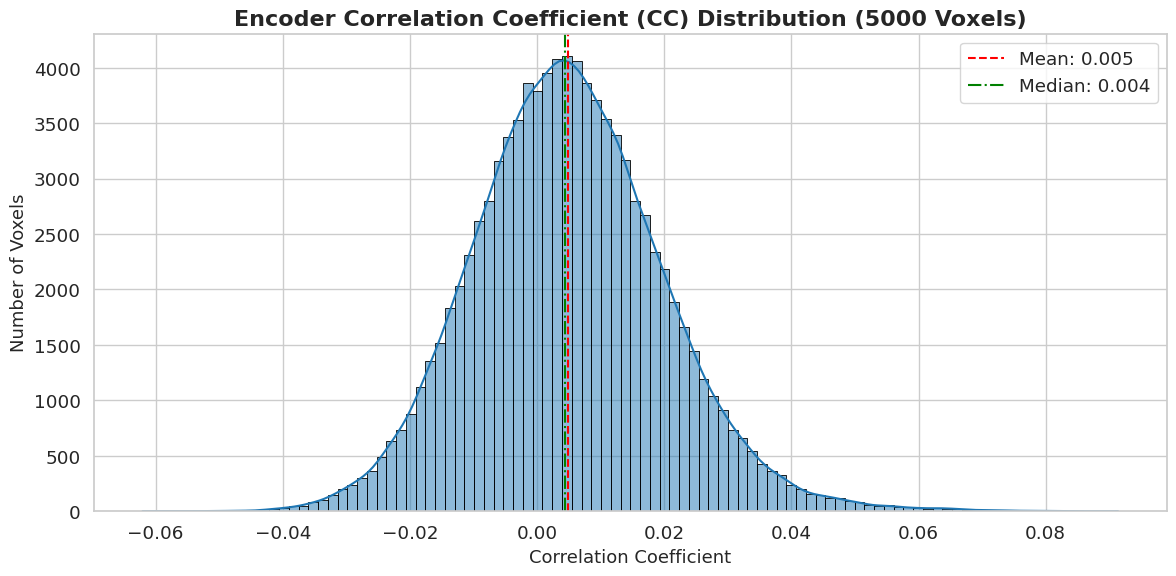

Plot saved to: ../results/cc_distribution_encoder_subject2_5000vox.png


In [13]:
import numpy as np
import os
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns

# --------- Setup ---------
story_names = list(raw_text.keys())
train_stories, test_stories = train_test_split(story_names, test_size=0.2, random_state=42)

subject2_path = os.path.join(data_path, "subject2")
X_train = []
Y_train = []



for story in train_stories:
    if story in X_encoder_lagged:
        bold_path = os.path.join(subject2_path, f"{story}.npy")
        if os.path.exists(bold_path):
            Y = np.load(bold_path)
            X = X_encoder_lagged[story]
            min_len = min(X.shape[0], Y.shape[0])
            X_train.append(X[:min_len])
            Y_train.append(Y[:min_len])
        else:
            print(f"Missing Y file for: {story}")

X_train = np.vstack(X_train)
Y_train = np.vstack(Y_train)
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)

# --------- Clean NaNs ---------
mask = ~np.isnan(Y_train).any(axis=1)
X_train_clean = X_train[mask]
Y_train_clean = Y_train[mask]

# --------- Cross Validation ---------
ridge = Ridge(alpha=100.0)
cv_scores = cross_val_score(ridge, X_train_clean, Y_train_clean, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores):.4f}")

# --------- Train Model ---------
ridge.fit(X_train_clean, Y_train_clean)

# --------- Evaluate on Test Set ---------
X_test = []
Y_test = []

for story in test_stories:
    if story in X_encoder_lagged:
        bold_path = os.path.join(subject2_path, f"{story}.npy")
        if os.path.exists(bold_path):
            Y = np.load(bold_path)
            X = X_encoder_lagged[story]
            min_len = min(X.shape[0], Y.shape[0])
            X_test.append(X[:min_len])
            Y_test.append(Y[:min_len])
        else:
            print(f"Missing Y file for: {story}")

X_test = np.vstack(X_test)
Y_test = np.vstack(Y_test)

# Clean NaNs from test
mask = ~np.isnan(Y_test).any(axis=1)
X_test_clean = X_test[mask]
Y_test_clean = Y_test[mask]

# Predict
Y_pred = ridge.predict(X_test_clean)

# --------- Compute Correlation Coefficients (CCs) ---------
def compute_voxel_ccs(y_true, y_pred):
    ccs = []
    for i in range(y_true.shape[1]):
        try:
            cc, _ = pearsonr(y_true[:, i], y_pred[:, i])
        except:
            cc = np.nan
        ccs.append(cc)
    return np.array(ccs)

ccs_encoder = compute_voxel_ccs(Y_test_clean, Y_pred)

print(f"Mean CC: {np.mean(ccs_encoder):.4f}")
print(f"Median CC: {np.median(ccs_encoder):.4f}")
print(f"Top 1% CC: {np.percentile(ccs_encoder, 99):.4f}")
print(f"Top 5% CC: {np.percentile(ccs_encoder, 95):.4f}")

# --------- Visualization ---------
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 6))

sns.histplot(ccs_encoder[~np.isnan(ccs_encoder)], bins=100, kde=True, color="#1f77b4", edgecolor="black", stat="count")
plt.axvline(np.mean(ccs_encoder), color='red', linestyle='--', label=f"Mean: {np.mean(ccs_encoder):.3f}")
plt.axvline(np.median(ccs_encoder), color='green', linestyle='-.', label=f"Median: {np.median(ccs_encoder):.3f}")
plt.title("Encoder Correlation Coefficient (CC) Distribution (5000 Voxels)", fontsize=16, weight="bold")
plt.xlabel("Correlation Coefficient", fontsize=13)
plt.ylabel("Number of Voxels", fontsize=13)
plt.legend()
plt.tight_layout()

# Save plot
save_dir = os.path.join("..", "results")
os.makedirs(save_dir, exist_ok=True)
plot_path = os.path.join(save_dir, "cc_distribution_encoder_subject2_5000vox.png")
plt.savefig(plot_path, dpi=300)
plt.show()

print(f"Plot saved to: {plot_path}")
